In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import numpy as np
import optuna

In [7]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
min_max_scaler = MinMaxScaler()
window_size = 5
horizon = 1

# Functions

In [8]:
#
def currentdata(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.reset_index(inplace=True)
    data['Date'] = data['Date'].dt.strftime('%d-%m-%Y')
    
    def str_to_datetime(s):
        split = s.split('-')
        day, month, year = int(split[0]), int(split[1]), int(split[2])
        return datetime.datetime(day=day, month=month, year=year)
    data['Date'] = data['Date'].apply(str_to_datetime)
    
    first_row = data.iloc[:1]
    rest_of_data = data.iloc[1:]
    rest_of_data = rest_of_data[rest_of_data['Volume'] != 0]

    data = pd.concat([first_row, rest_of_data])
    data = data[['Date', 'Close']]
    data.index = data.pop('Date')
    return data

#
def create_dataset(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[(i + window_size):(i + window_size + horizon)])
    return np.array(X), np.array(y)

#
def create_model(model_type, window_size, horizon, units):
    model = Sequential()
    
    # Add the recurrent layer
    if model_type == 'LSTM':
        model.add(LSTM(units, activation = 'relu', return_sequences=False, input_shape=(window_size,1)))
    elif model_type == 'GRU':
        model.add(GRU(units, activation = 'relu', return_sequences=False, input_shape=(window_size,1)))
    
    # Add the output layer
    model.add(Dense(horizon))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mae')
    
    return model

def create_windows_horizons(series, window_size, horizon_size):
    X, y = [], []
    for i in range(len(series) - window_size - horizon_size + 1):
        X.append(series[i:(i + window_size)])
        y.append(series[i + window_size:i + window_size + horizon_size])
    return np.array(X), np.array(y).reshape(-1, horizon_size)

def create_model_lstm(trial):
    model = Sequential()
    
    # Defining the number of units in LSTM layers
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    
    # Defining dropout rate
    # dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5, step=0.1)
    
    model.add(LSTM(units=lstm_units, return_sequences=False, input_shape=(5, 1)))
    # model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=1))  # Output layer
    model.compile(loss="mae", optimizer="adam")

    return model

def create_model_gru(trial):
    model = Sequential()
    
    # Defining the number of units in LSTM layers
    gru_units = trial.suggest_categorical('gru_units', [32, 64, 128])

    model.add(GRU(units=gru_units, return_sequences=False, input_shape=(5, 1)))
    
    model.add(Dense(units=1))  # Output layer
    model.compile(loss="mae", optimizer="adam")

    return model

def objective_lstm(trial):
    close_prices = train_df['Close'].values

    X, y = create_windows_horizons(close_prices, 5, 1)
    
    # Define the cross-validation technique
    tscv = TimeSeriesSplit(n_splits=5)
    
    val_losses = []  # List to store validation losses for each fold
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = create_model_lstm(trial)
        early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
        history = model.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=200,
                            batch_size=trial.suggest_categorical('batch_size', [32, 64, 128]),
                            callbacks=[early_stopping],
                            verbose=0)
        
        val_losses.append(min(history.history['val_loss']))
    
    # Calculate average validation loss across all folds
    avg_val_loss = np.mean(val_losses)
    return avg_val_loss

def objective_gru(trial):
    close_prices = train_df['Close'].values

    X, y = create_windows_horizons(close_prices, 5, 1)
    
    # Define the cross-validation technique
    tscv = TimeSeriesSplit(n_splits=5)
    
    val_losses = []  # List to store validation losses for each fold
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = create_model_gru(trial)
        early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
        history = model.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=200,
                            batch_size=trial.suggest_categorical('batch_size', [32, 64, 128]),
                            callbacks=[early_stopping],
                            verbose=0)
        
        val_losses.append(min(history.history['val_loss']))
    
    # Calculate average validation loss across all folds
    avg_val_loss = np.mean(val_losses)
    return avg_val_loss

# Optuna Hyperparameter Tuning
def optimize_lstm():
    study = optuna.create_study(direction='minimize')
    study.optimize(objective_lstm, n_trials=30)
    best_params = study.best_params
    print("Best Hyperparameters:", best_params)
def optimize_gru():
    study = optuna.create_study(direction='minimize')
    study.optimize(objective_gru, n_trials=30)
    best_params = study.best_params
    print("Best Hyperparameters:", best_params)

# Data Preparation

In [96]:
# set date for train-test dataset
start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 5, 1)

In [118]:
data = yf.Ticker("BBCA.JK")
train_df = data.history(start=start_train, end=end_train)

# Buang data yang Volume = 0
# train_df = train_df[train_df['Volume'] != 0]

# train_df

In [101]:
test_df = data.history(start=start_test, end=end_test)
# test_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-01-02 00:00:00+07:00,9188.267221,9212.704102,9139.393459,9212.704102,30545200,0.0,0.0
2024-01-03 00:00:00+07:00,9212.704198,9212.704198,9114.956674,9139.393555,34603300,0.0,0.0
2024-01-04 00:00:00+07:00,9188.267480,9261.578125,9163.830599,9261.578125,56501800,0.0,0.0
2024-01-05 00:00:00+07:00,9286.014554,9383.762076,9261.577674,9359.325195,85290100,0.0,0.0
2024-01-08 00:00:00+07:00,9383.762076,9408.198956,9261.577674,9359.325195,50896000,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-24 00:00:00+07:00,9825.000000,9950.000000,9750.000000,9950.000000,132832700,0.0,0.0
2024-04-25 00:00:00+07:00,10000.000000,10000.000000,9700.000000,9775.000000,104874100,0.0,0.0
2024-04-26 00:00:00+07:00,9700.000000,9825.000000,9625.000000,9625.000000,100932900,0.0,0.0


In [ ]:
data = currentdata("BBCA.JK", start_train, end_train)

plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price IDR')
plt.show

# Cross Validation

In [92]:
data = currentdata("BBCA.JK", start_train, end_train)
data

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2019-01-01,5200.0
2019-01-02,5240.0
2019-01-03,5180.0
2019-01-04,5205.0
2019-01-07,5245.0
...,...
2023-12-21,9325.0
2023-12-22,9325.0
2023-12-27,9375.0


In [93]:
data = currentdata("BBCA.JK", start_train, end_train)
optimize_lstm()
optimize_gru()

# LSTM 128 32

[*********************100%%**********************]  1 of 1 completed
[I 2024-06-20 08:51:37,957] A new study created in memory with name: no-name-8f50ebe5-0583-4e4f-8714-0d1abc3594d1
[I 2024-06-20 08:53:35,076] Trial 0 finished with value: 3888.11552734375 and parameters: {'lstm_units': 128, 'batch_size': 64}. Best is trial 0 with value: 3888.11552734375.
[I 2024-06-20 08:55:29,711] Trial 1 finished with value: 3892.44189453125 and parameters: {'lstm_units': 128, 'batch_size': 64}. Best is trial 0 with value: 3888.11552734375.
[I 2024-06-20 08:56:44,642] Trial 2 finished with value: 3919.7828125 and parameters: {'lstm_units': 64, 'batch_size': 64}. Best is trial 0 with value: 3888.11552734375.
[I 2024-06-20 08:57:53,111] Trial 3 finished with value: 3937.04375 and parameters: {'lstm_units': 64, 'batch_size': 128}. Best is trial 0 with value: 3888.11552734375.
[I 2024-06-20 08:59:01,937] Trial 4 finished with value: 3933.3484375 and parameters: {'lstm_units': 32, 'batch_size': 64}. Best

Best Hyperparameters: {'lstm_units': 128, 'batch_size': 32}


[I 2024-06-20 09:46:07,815] Trial 0 finished with value: 3817.888232421875 and parameters: {'gru_units': 64, 'batch_size': 32}. Best is trial 0 with value: 3817.888232421875.
[I 2024-06-20 09:47:31,512] Trial 1 finished with value: 3886.8013671875 and parameters: {'gru_units': 128, 'batch_size': 128}. Best is trial 0 with value: 3817.888232421875.
[I 2024-06-20 09:49:36,668] Trial 2 finished with value: 3702.83388671875 and parameters: {'gru_units': 128, 'batch_size': 32}. Best is trial 2 with value: 3702.83388671875.
[I 2024-06-20 09:50:57,591] Trial 3 finished with value: 3825.673681640625 and parameters: {'gru_units': 64, 'batch_size': 32}. Best is trial 2 with value: 3702.83388671875.
[I 2024-06-20 09:51:56,606] Trial 4 finished with value: 3913.920361328125 and parameters: {'gru_units': 32, 'batch_size': 64}. Best is trial 2 with value: 3702.83388671875.
[I 2024-06-20 09:52:55,987] Trial 5 finished with value: 3916.06123046875 and parameters: {'gru_units': 64, 'batch_size': 128}. 

Best Hyperparameters: {'gru_units': 128, 'batch_size': 32}


In [94]:
data = currentdata("BBRI.JK", start_train, end_train)
optimize_lstm()
optimize_gru()

[*********************100%%**********************]  1 of 1 completed
[I 2024-06-20 10:34:00,715] A new study created in memory with name: no-name-2d298995-09ef-458d-8d31-72b797463416
[I 2024-06-20 10:35:27,204] Trial 0 finished with value: 3897.22529296875 and parameters: {'lstm_units': 64, 'batch_size': 32}. Best is trial 0 with value: 3897.22529296875.
[I 2024-06-20 10:37:29,811] Trial 1 finished with value: 3840.215625 and parameters: {'lstm_units': 128, 'batch_size': 32}. Best is trial 1 with value: 3840.215625.
[I 2024-06-20 10:38:44,429] Trial 2 finished with value: 3922.359033203125 and parameters: {'lstm_units': 64, 'batch_size': 64}. Best is trial 1 with value: 3840.215625.
[I 2024-06-20 10:39:34,914] Trial 3 finished with value: 3943.807177734375 and parameters: {'lstm_units': 32, 'batch_size': 128}. Best is trial 1 with value: 3840.215625.
[I 2024-06-20 10:40:53,377] Trial 4 finished with value: 3918.8677734375 and parameters: {'lstm_units': 32, 'batch_size': 32}. Best is tr

Best Hyperparameters: {'lstm_units': 128, 'batch_size': 32}


[I 2024-06-20 11:25:47,627] Trial 0 finished with value: 3919.66337890625 and parameters: {'gru_units': 32, 'batch_size': 64}. Best is trial 0 with value: 3919.66337890625.
[I 2024-06-20 11:27:08,422] Trial 1 finished with value: 3825.4994140625 and parameters: {'gru_units': 64, 'batch_size': 32}. Best is trial 1 with value: 3825.4994140625.
[I 2024-06-20 11:27:58,748] Trial 2 finished with value: 3933.068310546875 and parameters: {'gru_units': 32, 'batch_size': 128}. Best is trial 1 with value: 3825.4994140625.
[I 2024-06-20 11:29:18,484] Trial 3 finished with value: 3878.985400390625 and parameters: {'gru_units': 32, 'batch_size': 32}. Best is trial 1 with value: 3825.4994140625.
[I 2024-06-20 11:30:37,206] Trial 4 finished with value: 3822.29267578125 and parameters: {'gru_units': 64, 'batch_size': 32}. Best is trial 4 with value: 3822.29267578125.
[I 2024-06-20 11:31:40,264] Trial 5 finished with value: 3889.7935546875 and parameters: {'gru_units': 64, 'batch_size': 64}. Best is tr

Best Hyperparameters: {'gru_units': 128, 'batch_size': 32}


In [95]:
data = currentdata("BMRI.JK", start_train, end_train)
optimize_lstm()
optimize_gru()

[*********************100%%**********************]  1 of 1 completed
[I 2024-06-20 12:12:01,224] A new study created in memory with name: no-name-214aa4f9-aa0f-4da6-b691-7fefdc1c604c
[I 2024-06-20 12:12:51,133] Trial 0 finished with value: 3944.537451171875 and parameters: {'lstm_units': 32, 'batch_size': 128}. Best is trial 0 with value: 3944.537451171875.
[I 2024-06-20 12:13:41,519] Trial 1 finished with value: 3944.838427734375 and parameters: {'lstm_units': 32, 'batch_size': 128}. Best is trial 0 with value: 3944.537451171875.
[I 2024-06-20 12:14:41,255] Trial 2 finished with value: 3937.9712890625 and parameters: {'lstm_units': 64, 'batch_size': 128}. Best is trial 2 with value: 3937.9712890625.
[I 2024-06-20 12:15:53,329] Trial 3 finished with value: 3923.82744140625 and parameters: {'lstm_units': 64, 'batch_size': 64}. Best is trial 3 with value: 3923.82744140625.
[I 2024-06-20 12:17:51,223] Trial 4 finished with value: 3826.960498046875 and parameters: {'lstm_units': 128, 'batc

Best Hyperparameters: {'lstm_units': 128, 'batch_size': 32}


[I 2024-06-20 13:02:09,350] Trial 0 finished with value: 3918.24736328125 and parameters: {'gru_units': 64, 'batch_size': 128}. Best is trial 0 with value: 3918.24736328125.
[I 2024-06-20 13:03:08,328] Trial 1 finished with value: 3917.998974609375 and parameters: {'gru_units': 64, 'batch_size': 128}. Best is trial 1 with value: 3917.998974609375.
[I 2024-06-20 13:04:26,527] Trial 2 finished with value: 3884.107275390625 and parameters: {'gru_units': 128, 'batch_size': 128}. Best is trial 2 with value: 3884.107275390625.
[I 2024-06-20 13:05:41,976] Trial 3 finished with value: 3884.7119140625 and parameters: {'gru_units': 128, 'batch_size': 128}. Best is trial 2 with value: 3884.107275390625.
[I 2024-06-20 13:07:42,414] Trial 4 finished with value: 3692.602978515625 and parameters: {'gru_units': 128, 'batch_size': 32}. Best is trial 4 with value: 3692.602978515625.
[I 2024-06-20 13:08:41,296] Trial 5 finished with value: 3914.40322265625 and parameters: {'gru_units': 32, 'batch_size': 

Best Hyperparameters: {'gru_units': 128, 'batch_size': 32}


# Modeling

## BCA

### BCA Data Prep

In [6]:
# set date for train-test dataset
start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)
# end_test = datetime.datetime.now()

# yf.download("BBCA.JK", start=start_train, end=end_test)

In [7]:
train_df = currentdata("BBCA.JK", start_train, end_train)

# Buang data yang Volume = 0
# train_df = train_df[train_df['Volume'] != 0]

[*********************100%%**********************]  1 of 1 completed


In [8]:
test_df = currentdata("BBCA.JK", start_test, end_test)
# test_df

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2024-01-02,9425.0
2024-01-03,9350.0
2024-01-04,9475.0
2024-01-05,9575.0
2024-01-08,9575.0
...,...
2024-05-27,9300.0
2024-05-28,9300.0
2024-05-29,9150.0


### BCA LSTM

In [9]:
import os

best_model_mape = float('inf')
best_model_name = ""

close_train = train_df['Close'].values
close_test = test_df['Close'].values
date_train = train_df.index
date_test = test_df.index

# Konfigurasi window size dan horizon
configs = [
    {'window_size': 5, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 20, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 60, 'horizon': horizon, 'units':128, 'batch_size':32}
]

results = []

for config in configs:
    window_size = config['window_size']
    horizon = config['horizon']
    units = config['units']
    batch_size = config['batch_size']

    # Siapkan dataset
    X_train, y_train = create_windows_horizons(close_train, window_size, horizon)
    X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

    # Buat dan latih model
    model = create_model('LSTM', window_size, horizon, units)
    early_stopping = EarlyStopping(monitor='loss', patience=150, restore_best_weights=True)
    lstmBCA = model.fit(
        X_train, y_train,
        # validation_data=(X_test, y_test),
        epochs=1000,
        batch_size = batch_size,
        callbacks=[early_stopping],
        verbose=0
        )
    
    # Prediksi pada data testing
    y_pred = model.predict(X_test)
    
    # Evaluasi model dengan MAE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    model_name = f"BBCA_LSTM_window_{config['window_size']}.h5"
    model.save(model_name)
    
    # # Update best model tracking
    # if mape < best_model_mape:
    #     best_model_mape = mape
    #     if best_model_name:
    #         # Delete previous best model
    #         os.remove(best_model_name)
    #     best_model_name = model_name
    # else:
    #     # Delete the current model as it's not the best
    #     os.remove(model_name)

    results.append({
        'config': config,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred,
        'y_test': y_test,
        'X_test': X_test
    })

# Tampilkan hasil
for result in results:
    config = result['config']
    mae = result['mae']
    rmse = result['rmse']
    mape = result['mape']
    y_pred = result['y_pred']
    y_test = result['y_test']
    X_test = result['X_test']
    
    print(f"Config: {config} - MAE: {mae} - RMSE: {rmse} - MAPE: {mape}")
    
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 104.93553565014368 - RMSE: 137.7854701341109 - MAPE: 1.0833710416530713
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 115.97678699712644 - RMSE: 147.86183777678343 - MAPE: 1.1991364485359344
# Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 132.28194173177084 - RMSE: 166.61437468317436 - MAPE: 1.35610841456208
# Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 694.0199279785156 - RMSE: 760.965924095283 - MAPE: 7.342271470311354

1/1 [==============================] - 0s 124ms/step
Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 115.97678699712644 - RMSE: 147.86183777678343 - MAPE: 1.1991364485359344
Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 132.28194173177084 - RMSE: 166.61437468317436 - MAPE: 1.35610841456208
Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 694.0199279785156 - RMSE: 760.965924095283 - MAPE: 7.342271470311354


### BCA GRU

In [10]:
import os

best_model_mape = float('inf')
best_model_name = ""

close_train = train_df['Close'].values
close_test = test_df['Close'].values
date_train = train_df.index
date_test = test_df.index

# Konfigurasi window size dan horizon
configs = [
    {'window_size': 5, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 20, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 60, 'horizon': horizon, 'units':128, 'batch_size':32}
]

results = []

for config in configs:
    window_size = config['window_size']
    horizon = config['horizon']
    units = config['units']
    batch_size = config['batch_size']

    # Siapkan dataset
    X_train, y_train = create_windows_horizons(close_train, window_size, horizon)
    X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

    # Buat dan latih model
    model = create_model('GRU', window_size, horizon, units)
    early_stopping = EarlyStopping(monitor='loss', patience=150, restore_best_weights=True)
    lstmBCA = model.fit(
        X_train, y_train,
        # validation_data=(X_test, y_test),
        epochs=1000,
        batch_size = batch_size,
        callbacks=[early_stopping],
        verbose=0
        )
    
    # Prediksi pada data testing
    y_pred = model.predict(X_test)
    
    # Evaluasi model dengan MAE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    model_name = f"BBCA_GRU_window_{config['window_size']}.h5"
    model.save(model_name)
    
    # # Update best model tracking
    # if mape < best_model_mape:
    #     best_model_mape = mape
    #     if best_model_name:
    #         # Delete previous best model
    #         os.remove(best_model_name)
    #     best_model_name = model_name
    # else:
    #     # Delete the current model as it's not the best
    #     os.remove(model_name)

    results.append({
        'config': config,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred,
        'y_test': y_test,
        'X_test': X_test
    })

# Tampilkan hasil
for result in results:
    config = result['config']
    mae = result['mae']
    rmse = result['rmse']
    mape = result['mape']
    y_pred = result['y_pred']
    y_test = result['y_test']
    X_test = result['X_test']
    
    print(f"Config: {config} - MAE: {mae} - RMSE: {rmse} - MAPE: {mape}")
    
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 111.40372522865853 - RMSE: 147.31863438517325 - MAPE: 1.1466334885410787
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 107.58371497844827 - RMSE: 143.05051236614707 - MAPE: 1.1078633130792364
# Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 113.85785590277777 - RMSE: 148.01007781436402 - MAPE: 1.1736500459808492
# Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 156.35562133789062 - RMSE: 193.01647041935155 - MAPE: 1.6373977798643025

1/1 [==============================] - 0s 116ms/step
Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 107.58371497844827 - RMSE: 143.05051236614707 - MAPE: 1.1078633130792364
Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 113.85785590277777 - RMSE: 148.01007781436402 - MAPE: 1.1736500459808492
Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 156.35562133789062 - RMSE: 193.01647041935155 - MAPE: 1.6373977798643025


### BCA Naive

In [16]:
import numpy as np

start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)
train_df = currentdata("BBCA.JK", start_train, end_train)
test_df = currentdata("BBCA.JK", start_test, end_test)

close_train = train_df['Close'].values
close_test = test_df['Close'].values

# Create an array of the same length as y_test with the naive baseline value
naive_predictions = np.full_like(close_test, close_train[-1])

# Calculate the MAE (Mean Absolute Error) for the naive baseline
mae_naive = np.mean(np.abs(naive_predictions - close_test))

# Calculate the MAPE (Mean Absolute Percentage Error) for the naive baseline
mape_naive = np.mean(np.abs((naive_predictions - close_test) / close_test)) * 100

# Print the naive baseline, MAE, and MAPE
print("Naive Baseline Value:", close_train[-1])
print("MAE (Naive Baseline vs y_test):", mae_naive)
print("MAPE (Naive Baseline vs y_test):", mape_naive)
print(naive_predictions.shape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Naive Baseline Value: 9400.0
MAE (Naive Baseline vs y_test): 341.8478260869565
MAPE (Naive Baseline vs y_test): 3.4663622391317865
(92,)


## BRI

### BRI Data Prep

In [64]:
# set date for train-test dataset
start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)

In [65]:
train_df = currentdata("BBRI.JK", start_train, end_train)
# train_df

[*********************100%%**********************]  1 of 1 completed


In [66]:
test_df = currentdata("BBRI.JK", start_test, end_test)
# test_df

[*********************100%%**********************]  1 of 1 completed


### BRI LSTM

In [14]:
import os

best_model_mape = float('inf')
best_model_name = ""

close_train = train_df['Close'].values
close_test = test_df['Close'].values
date_train = train_df.index
date_test = test_df.index

# Konfigurasi window size dan horizon
configs = [
    {'window_size': 5, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 20, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 60, 'horizon': horizon, 'units':128, 'batch_size':32}
]

results = []

for config in configs:
    window_size = config['window_size']
    horizon = config['horizon']
    units = config['units']
    batch_size = config['batch_size']

    # Siapkan dataset
    X_train, y_train = create_windows_horizons(close_train, window_size, horizon)
    X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

    # Buat dan latih model
    model = create_model('LSTM', window_size, horizon, units)
    early_stopping = EarlyStopping(monitor='loss', patience=150, restore_best_weights=True)
    lstmBCA = model.fit(
        X_train, y_train,
        # validation_data=(X_test, y_test),
        epochs=1000,
        batch_size = batch_size,
        callbacks=[early_stopping],
        verbose=0
        )
    
    # Prediksi pada data testing
    y_pred = model.predict(X_test)
    
    # Evaluasi model dengan MAE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    model_name = f"BBRI_LSTM_window_{config['window_size']}.h5"
    model.save(model_name)
    
    # # Update best model tracking
    # if mape < best_model_mape:
    #     best_model_mape = mape
    #     if best_model_name:
    #         # Delete previous best model
    #         os.remove(best_model_name)
    #     best_model_name = model_name
    # else:
    #     # Delete the current model as it's not the best
    #     os.remove(model_name)

    results.append({
        'config': config,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred,
        'y_test': y_test,
        'X_test': X_test
    })

# Tampilkan hasil
for result in results:
    config = result['config']
    mae = result['mae']
    rmse = result['rmse']
    mape = result['mape']
    y_pred = result['y_pred']
    y_test = result['y_test']
    X_test = result['X_test']
    
    print(f"Config: {config} - MAE: {mae} - RMSE: {rmse} - MAPE: {mape}")
    
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 85.69625538793103 - RMSE: 111.16492137369004 - MAPE: 1.5619108902789571
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 84.18780307112068 - RMSE: 109.20056417096403 - MAPE: 1.5329569917180335
# Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 147.46470811631946 - RMSE: 185.50290078025498 - MAPE: 2.753236105104224
# Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 352.9589385986328 - RMSE: 412.8371909149512 - MAPE: 7.051473028907084

1/1 [==============================] - 0s 97ms/step
Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 84.18780307112068 - RMSE: 109.20056417096403 - MAPE: 1.5329569917180335
Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 147.46470811631946 - RMSE: 185.50290078025498 - MAPE: 2.753236105104224
Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 352.9589385986328 - RMSE: 412.8371909149512 - MAPE: 7.051473028907084


### BRI GRU

In [67]:
import os

best_model_mape = float('inf')
best_model_name = ""

close_train = train_df['Close'].values
close_test = test_df['Close'].values
date_train = train_df.index
date_test = test_df.index

# Konfigurasi window size dan horizon
configs = [
    {'window_size': 5, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 20, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 60, 'horizon': horizon, 'units':128, 'batch_size':32}
]

results = []

for config in configs:
    window_size = config['window_size']
    horizon = config['horizon']
    units = config['units']
    batch_size = config['batch_size']

    # Siapkan dataset
    X_train, y_train = create_windows_horizons(close_train, window_size, horizon)
    X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

    # Buat dan latih model
    model = create_model('GRU', window_size, horizon, units)
    early_stopping = EarlyStopping(monitor='loss', patience=150, restore_best_weights=True)
    lstmBCA = model.fit(
        X_train, y_train,
        # validation_data=(X_test, y_test),
        epochs=1000,
        batch_size = batch_size,
        callbacks=[early_stopping],
        verbose=0
        )
    
    # Prediksi pada data testing
    y_pred = model.predict(X_test)
    
    # Evaluasi model dengan MAE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    model_name = f"BBRI_GRU_window_{config['window_size']}.h5"
    model.save(model_name)
    
    # # Update best model tracking
    # if mape < best_model_mape:
    #     best_model_mape = mape
    #     if best_model_name:
    #         # Delete previous best model
    #         os.remove(best_model_name)
    #     best_model_name = model_name
    # else:
    #     # Delete the current model as it's not the best
    #     os.remove(model_name)

    results.append({
        'config': config,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred,
        'y_test': y_test,
        'X_test': X_test
    })

# Tampilkan hasil
for result in results:
    config = result['config']
    mae = result['mae']
    rmse = result['rmse']
    mape = result['mape']
    y_pred = result['y_pred']
    y_test = result['y_test']
    X_test = result['X_test']
    
    print(f"Config: {config} - MAE: {mae} - RMSE: {rmse} - MAPE: {mape}")
    

# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 85.4964248832615 - RMSE: 112.06800504812148 - MAPE: 1.5625930928322096
# Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 91.71395534939236 - RMSE: 113.6044726237498 - MAPE: 1.6518207169919248
# Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 88.41236877441406 - RMSE: 115.53708686744562 - MAPE: 1.7869388829985635

1/1 [==============================] - 0s 107ms/step
Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 85.4964248832615 - RMSE: 112.06800504812148 - MAPE: 1.5625930928322096
Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 91.71395534939236 - RMSE: 113.6044726237498 - MAPE: 1.6518207169919248
Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 88.41236877441406 - RMSE: 115.53708686744562 - MAPE: 1.7869388829985635


### BRI Naive

In [15]:
import numpy as np

start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)
train_df = currentdata("BBRI.JK", start_train, end_train)
test_df = currentdata("BBRI.JK", start_test, end_test)

close_train = train_df['Close'].values
close_test = test_df['Close'].values

# Create an array of the same length as y_test with the naive baseline value
naive_predictions = np.full_like(close_test, close_train[-1])

# Calculate the MAE (Mean Absolute Error) for the naive baseline
mae_naive = np.mean(np.abs(naive_predictions - close_test))

# Calculate the MAPE (Mean Absolute Percentage Error) for the naive baseline
mape_naive = np.mean(np.abs((naive_predictions - close_test) / close_test)) * 100

# Print the naive baseline, MAE, and MAPE
print("Naive Baseline Value:", close_train[-1])
print("MAE (Naive Baseline vs y_test):", mae_naive)
print("MAPE (Naive Baseline vs y_test):", mape_naive)
print(naive_predictions.shape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Naive Baseline Value: 5725.0
MAE (Naive Baseline vs y_test): 446.0869565217391
MAPE (Naive Baseline vs y_test): 8.598314483675585
(92,)


## MRI

### MRI Data Prep

In [68]:
# set date for train-test dataset
start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)

In [69]:
train_df = currentdata("BMRI.JK", start_train, end_train)
# train_df

[*********************100%%**********************]  1 of 1 completed


In [76]:
test_df = currentdata("BMRI.JK", start_test, end_test)
# test_df

[*********************100%%**********************]  1 of 1 completed


### MRI LSTM

In [19]:
import os

best_model_mape = float('inf')
best_model_name = ""

close_train = train_df['Close'].values
close_test = test_df['Close'].values
date_train = train_df.index
date_test = test_df.index

# Konfigurasi window size dan horizon
configs = [
    {'window_size': 5, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 20, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 60, 'horizon': horizon, 'units':128, 'batch_size':32}
]

results = []

for config in configs:
    window_size = config['window_size']
    horizon = config['horizon']
    units = config['units']
    batch_size = config['batch_size']

    # Siapkan dataset
    X_train, y_train = create_windows_horizons(close_train, window_size, horizon)
    X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

    # Buat dan latih model
    model = create_model('LSTM', window_size, horizon, units)
    early_stopping = EarlyStopping(monitor='loss', patience=150, restore_best_weights=True)
    lstmBCA = model.fit(
        X_train, y_train,
        # validation_data=(X_test, y_test),
        epochs=1000,
        batch_size = batch_size,
        callbacks=[early_stopping],
        verbose=0
        )
    
    # Prediksi pada data testing
    y_pred = model.predict(X_test)
    
    # Evaluasi model dengan MAE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    model_name = f"BMRI_LSTM_window_{config['window_size']}.h5"
    model.save(model_name)
    
    # # Update best model tracking
    # if mape < best_model_mape:
    #     best_model_mape = mape
    #     if best_model_name:
    #         # Delete previous best model
    #         os.remove(best_model_name)
    #     best_model_name = model_name
    # else:
    #     # Delete the current model as it's not the best
    #     os.remove(model_name)

    results.append({
        'config': config,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred,
        'y_test': y_test,
        'X_test': X_test
    })

# Tampilkan hasil
for result in results:
    config = result['config']
    mae = result['mae']
    rmse = result['rmse']
    mape = result['mape']
    y_pred = result['y_pred']
    y_test = result['y_test']
    X_test = result['X_test']
    
    print(f"Config: {config} - MAE: {mae} - RMSE: {rmse} - MAPE: {mape}")
    
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 103.19848352191092 - RMSE: 142.20988779551521 - MAPE: 1.5562594510536465
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 96.66766006645115 - RMSE: 137.66112197387218 - MAPE: 1.4549824904499102
# Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 117.08419460720486 - RMSE: 149.95556048033365 - MAPE: 1.7420718519158989
# Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 581.4672546386719 - RMSE: 698.4396684858189 - MAPE: 9.33784308801499

1/1 [==============================] - 0s 108ms/step
Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 96.66766006645115 - RMSE: 137.66112197387218 - MAPE: 1.4549824904499102
Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 117.08419460720486 - RMSE: 149.95556048033365 - MAPE: 1.7420718519158989
Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 581.4672546386719 - RMSE: 698.4396684858189 - MAPE: 9.33784308801499


### MRI GRU

In [20]:
import os

best_model_mape = float('inf')
best_model_name = ""

close_train = train_df['Close'].values
close_test = test_df['Close'].values
date_train = train_df.index
date_test = test_df.index

# Konfigurasi window size dan horizon
configs = [
    {'window_size': 5, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 20, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 60, 'horizon': horizon, 'units':128, 'batch_size':32}
]
results = []

for config in configs:
    window_size = config['window_size']
    horizon = config['horizon']
    units = config['units']
    batch_size = config['batch_size']

    # Siapkan dataset
    X_train, y_train = create_windows_horizons(close_train, window_size, horizon)
    X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

    # Buat dan latih model
    model = create_model('GRU', window_size, horizon, units)
    early_stopping = EarlyStopping(monitor='loss', patience=150, restore_best_weights=True)
    lstmBCA = model.fit(
        X_train, y_train,
        # validation_data=(X_test, y_test),
        epochs=1000,
        batch_size = batch_size,
        callbacks=[early_stopping],
        verbose=0
        )
    
    # Prediksi pada data testing
    y_pred = model.predict(X_test)
    
    # Evaluasi model dengan MAE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    model_name = f"BMRI_GRU_window_{config['window_size']}.h5"
    model.save(model_name)
    
    # # Update best model tracking
    # if mape < best_model_mape:
    #     best_model_mape = mape
    #     if best_model_name:
    #         # Delete previous best model
    #         os.remove(best_model_name)
    #     best_model_name = model_name
    # else:
    #     # Delete the current model as it's not the best
    #     os.remove(model_name)

    results.append({
        'config': config,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred,
        'y_test': y_test,
        'X_test': X_test
    })

# Tampilkan hasil
for result in results:
    config = result['config']
    mae = result['mae']
    rmse = result['rmse']
    mape = result['mape']
    y_pred = result['y_pred']
    y_test = result['y_test']
    X_test = result['X_test']
    
    print(f"Config: {config} - MAE: {mae} - RMSE: {rmse} - MAPE: {mape}")
    
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 95.17061781609195 - RMSE: 133.92838950989994 - MAPE: 1.429475067198436
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 96.42261584051724 - RMSE: 134.22127628453913 - MAPE: 1.445516075766683
# Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 111.03099229600694 - RMSE: 151.76471625216504 - MAPE: 1.6675282354037257
# Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 124.12548828125 - RMSE: 169.33133404872964 - MAPE: 1.9398026740487542

1/1 [==============================] - 0s 143ms/step
Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 96.42261584051724 - RMSE: 134.22127628453913 - MAPE: 1.445516075766683
Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 111.03099229600694 - RMSE: 151.76471625216504 - MAPE: 1.6675282354037257
Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 124.12548828125 - RMSE: 169.33133404872964 - MAPE: 1.9398026740487542


### MRI Naive

In [9]:
import numpy as np

start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)
train_df = currentdata("BMRI.JK", start_train, end_train)
test_df = currentdata("BMRI.JK", start_test, end_test)

close_train = train_df['Close'].values
close_test = test_df['Close'].values

# Create an array of the same length as y_test with the naive baseline value
naive_predictions = np.full_like(close_test, close_train[-1])

# Calculate the MAE (Mean Absolute Error) for the naive baseline
mae_naive = np.mean(np.abs(naive_predictions - close_test))

# Calculate the MAPE (Mean Absolute Percentage Error) for the naive baseline
mape_naive = np.mean(np.abs((naive_predictions - close_test) / close_test)) * 100
# Calculate the RMSE (Root Mean Squared Error) for the naive baseline
rmse_naive = np.sqrt(np.mean((naive_predictions - close_test) ** 2))

# Print the RMSE
print("RMSE (Naive Baseline vs y_test):", rmse_naive)
# Print the naive baseline, MAE, and MAPE
print("Naive Baseline Value:", close_train[-1])
print("MAE (Naive Baseline vs y_test):", mae_naive)
print("MAPE (Naive Baseline vs y_test):", mape_naive)
print(naive_predictions.shape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

RMSE (Naive Baseline vs y_test): 769.0735886653556
Naive Baseline Value: 6050.0
MAE (Naive Baseline vs y_test): 673.6413043478261
MAPE (Naive Baseline vs y_test): 9.753006145647191
(92,)


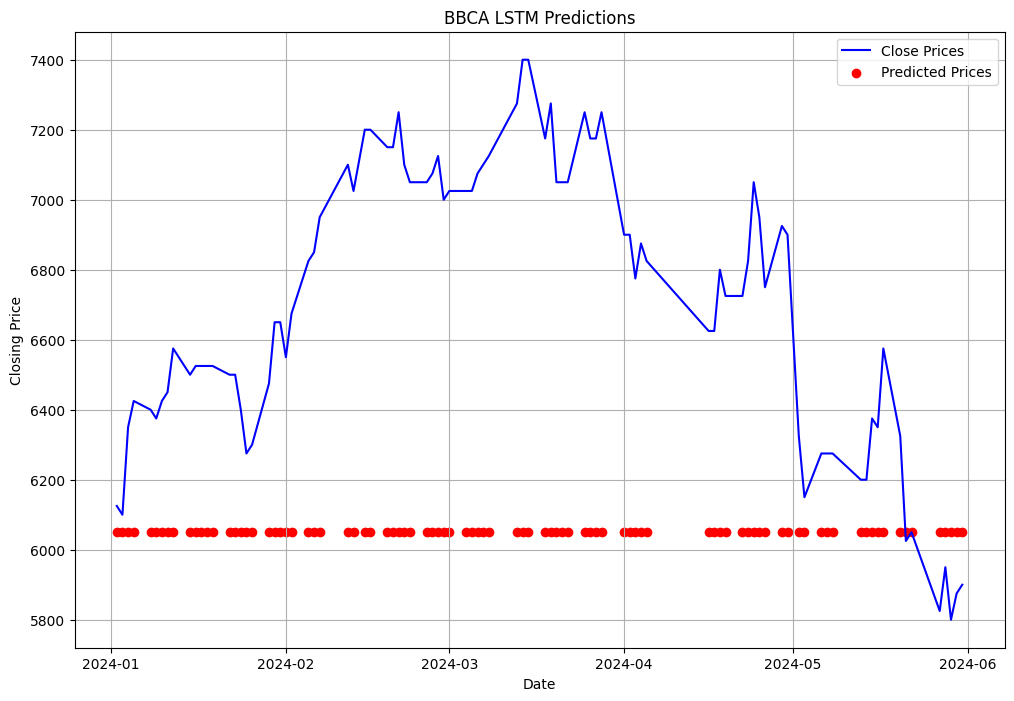

In [10]:
length_difference = len(test_df) - len(naive_predictions)

if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(naive_predictions, columns=['y_pred'])

test_df['y_pred'] = y_pred_df.values

test_df = test_df.dropna(subset=['y_pred'])


plt.figure(figsize=(12, 8))

# Plot 'close' with a blue line
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')

# Plot 'y_pred' with a red line
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

# Add a legend
plt.legend()

# Optionally, add titles and labels
plt.title('BBCA LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')

plt.grid(True)

# Display the plot
plt.show()

# Plotting

## BCA

### BCA LSTM

In [31]:
start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)

train_df = currentdata("BBCA.JK", start_train, end_train)
test_df = currentdata("BBCA.JK", start_test, end_test)

from keras.models import load_model

horizon = 1
close_test = test_df['Close'].values

window_size = 5
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model5 = load_model('BBCA_LSTM_window_5.h5')
pred5 = model.predict(X_test)

window_size = 20
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model20 = load_model('BBCA_LSTM_window_20.h5')
pred20 = model.predict(X_test)

window_size = 60
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model60 = load_model('BBCA_LSTM_window_60.h5')
pred60 = model.predict(X_test)

# Print the predictions
print(pred5.shape)
print(pred20.shape)
print(pred60.shape)

1/1 [==============================] - 0s 28ms/step
(87, 1)
(72, 1)
(32, 1)


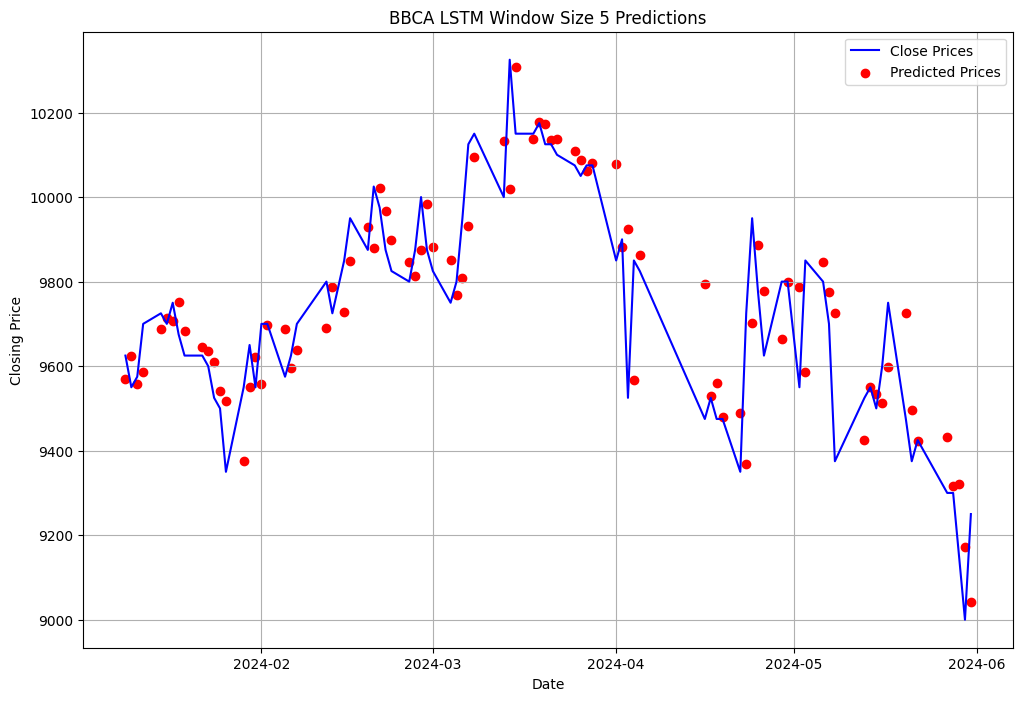

In [32]:
# Predictions for window size 5
length_difference = len(test_df) - len(pred5)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred5, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BBCA LSTM Window Size 5 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

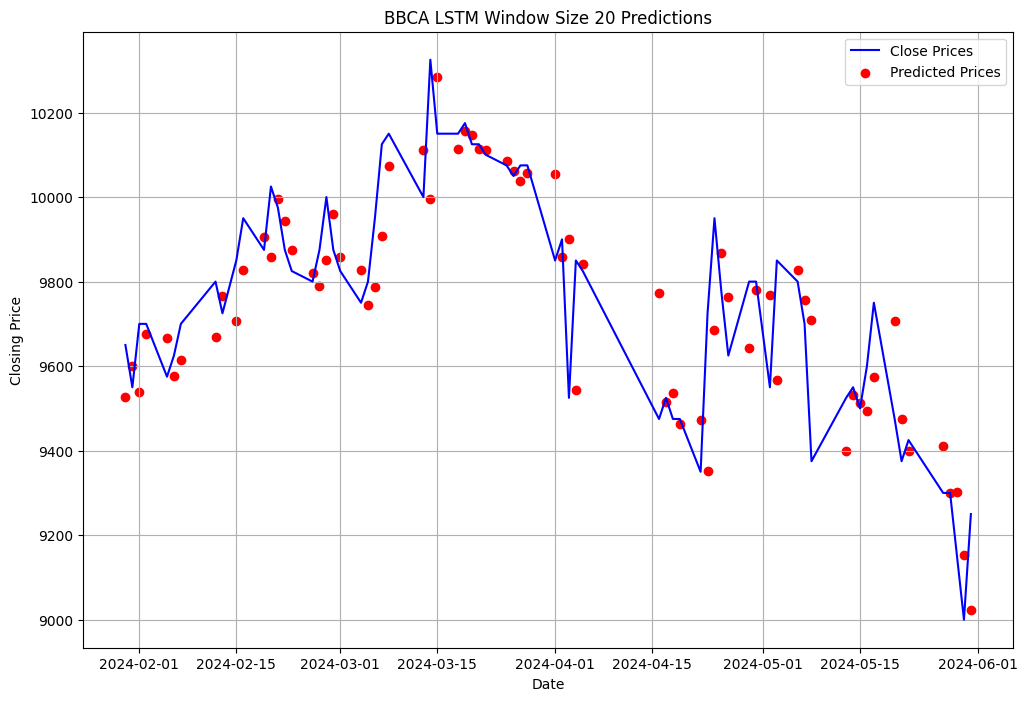

In [33]:
# Predictions for window size 20
length_difference = len(test_df) - len(pred20)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred20, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BBCA LSTM Window Size 20 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

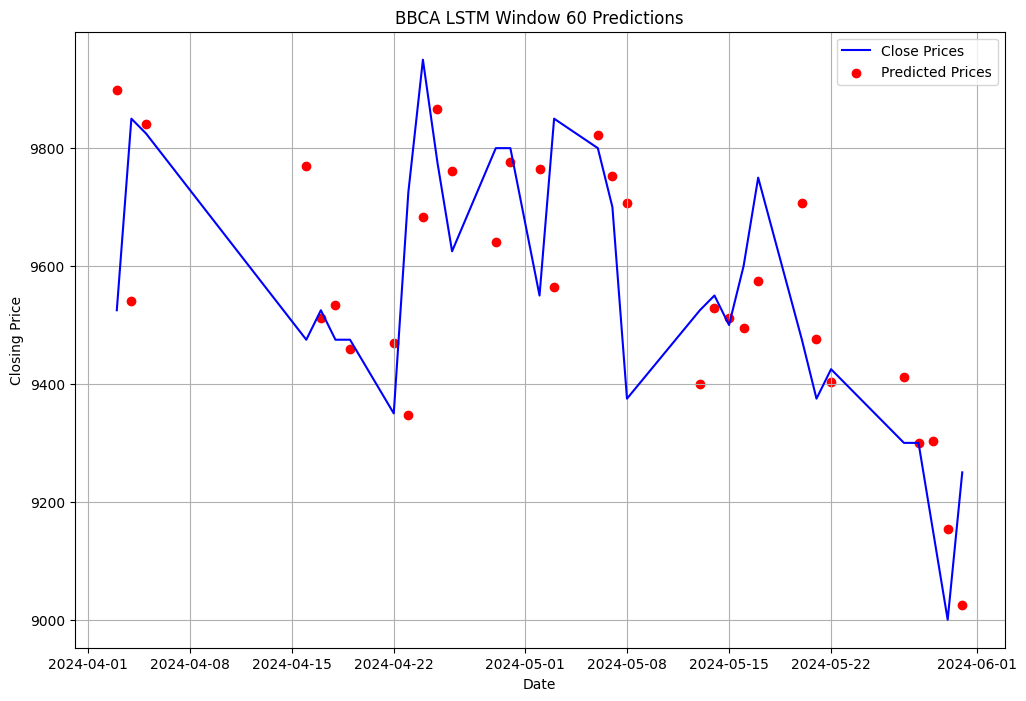

In [34]:
# Predictions for window size 60
length_difference = len(test_df) - len(pred60)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred60, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BBCA LSTM Window 60 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

### BCA GRU

In [36]:
start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)

train_df = currentdata("BBCA.JK", start_train, end_train)
test_df = currentdata("BBCA.JK", start_test, end_test)

from keras.models import load_model

horizon = 1
close_test = test_df['Close'].values

window_size = 5
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model5 = load_model('BBCA_GRU_window_5.h5')
pred5 = model.predict(X_test)

window_size = 20
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model20 = load_model('BBCA_GRU_window_20.h5')
pred20 = model.predict(X_test)

window_size = 60
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model60 = load_model('BBCA_GRU_window_60.h5')
pred60 = model.predict(X_test)

# Print the predictions
print(pred5.shape)
print(pred20.shape)
print(pred60.shape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 25ms/step
(87, 1)
(72, 1)
(32, 1)


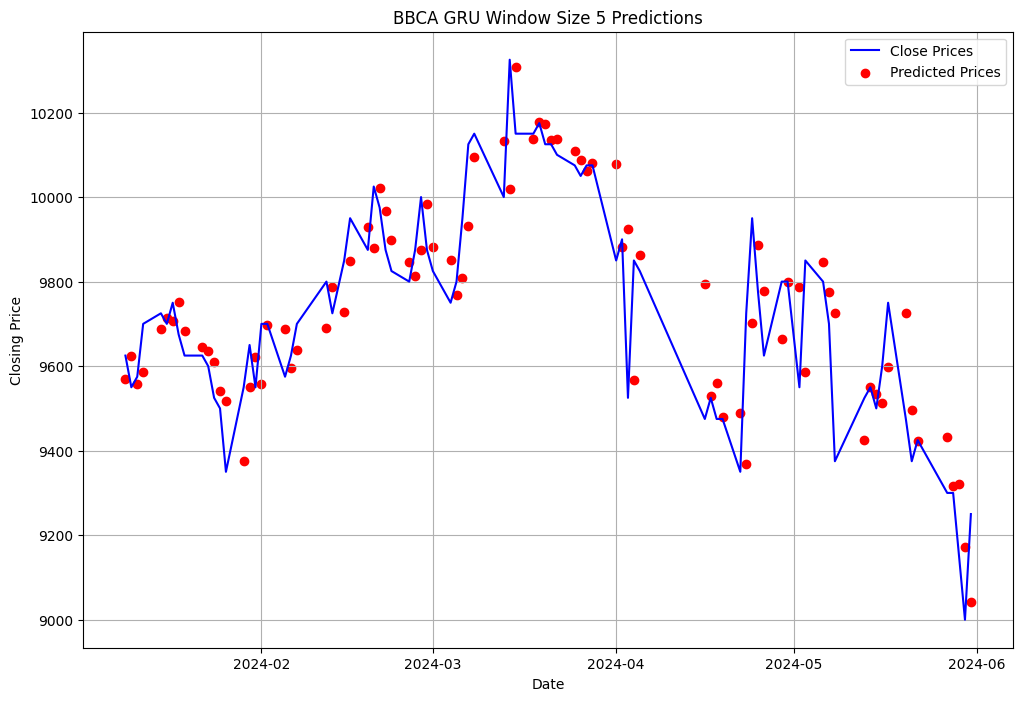

In [37]:
# Predictions for window size 5
length_difference = len(test_df) - len(pred5)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred5, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BBCA GRU Window Size 5 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

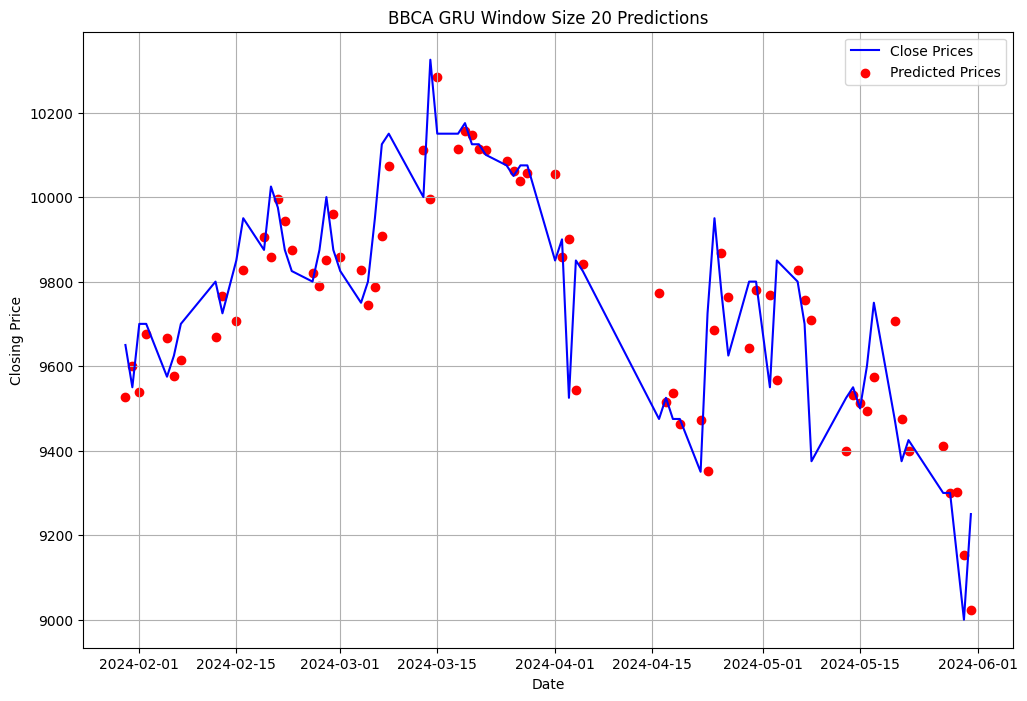

In [38]:
# Predictions for window size 20
length_difference = len(test_df) - len(pred20)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred20, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BBCA GRU Window Size 20 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

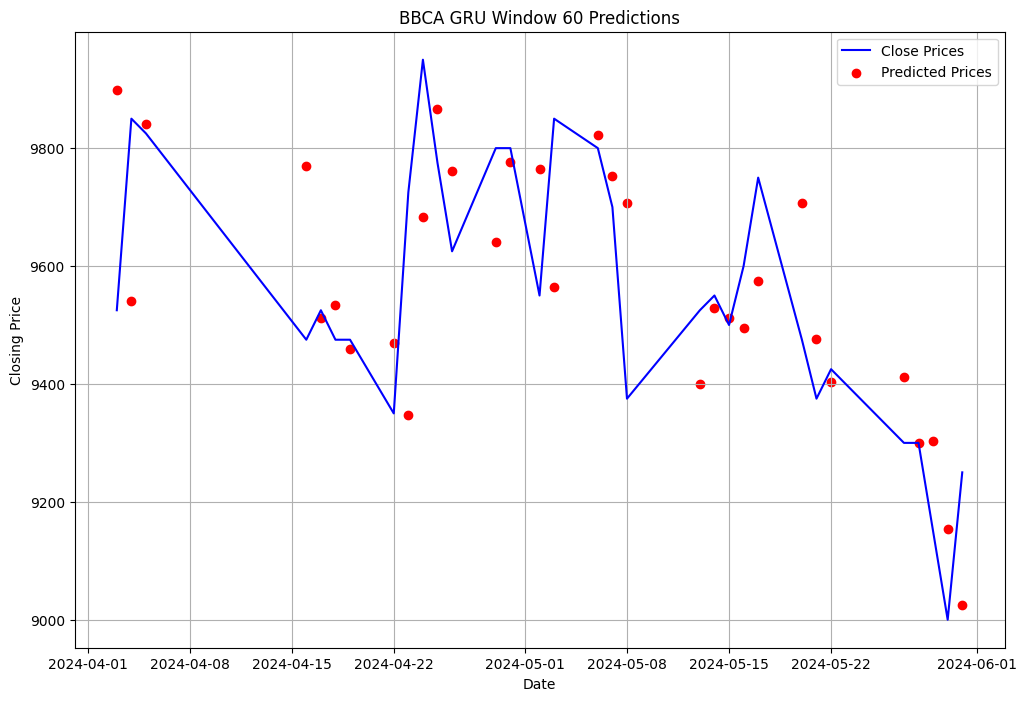

In [39]:
# Predictions for window size 60
length_difference = len(test_df) - len(pred60)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred60, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BBCA GRU Window 60 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

## BRI

### BRI LSTM

In [47]:
start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)

train_df = currentdata("BBRI.JK", start_train, end_train)
test_df = currentdata("BBRI.JK", start_test, end_test)

from keras.models import load_model

horizon = 1
close_test = test_df['Close'].values

window_size = 5
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model5 = load_model('BBRI_LSTM_window_5.h5')
pred5 = model.predict(X_test)

window_size = 20
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model20 = load_model('BBRI_LSTM_window_20.h5')
pred20 = model.predict(X_test)

window_size = 60
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model60 = load_model('BBRI_LSTM_window_60.h5')
pred60 = model.predict(X_test)

# Print the predictions
print(pred5.shape)
print(pred20.shape)
print(pred60.shape)

1/1 [==============================] - 0s 20ms/step
(87, 1)
(72, 1)
(32, 1)


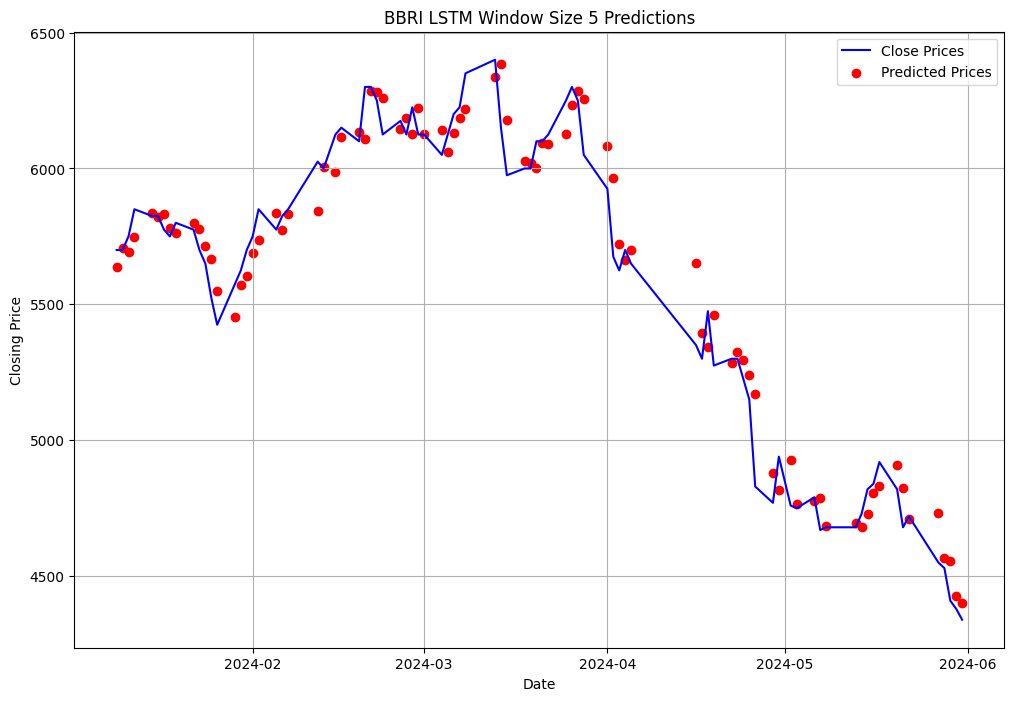

In [48]:
# Predictions for window size 5
length_difference = len(test_df) - len(pred5)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred5, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BBRI LSTM Window Size 5 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

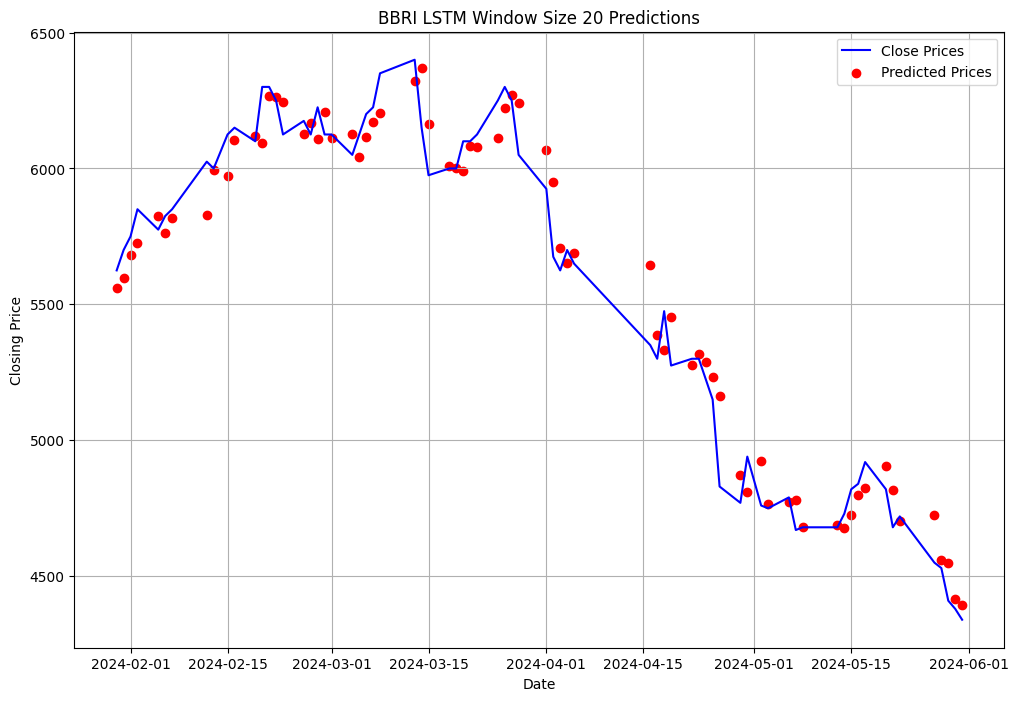

In [49]:
# Predictions for window size 20
length_difference = len(test_df) - len(pred20)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred20, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BBRI LSTM Window Size 20 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

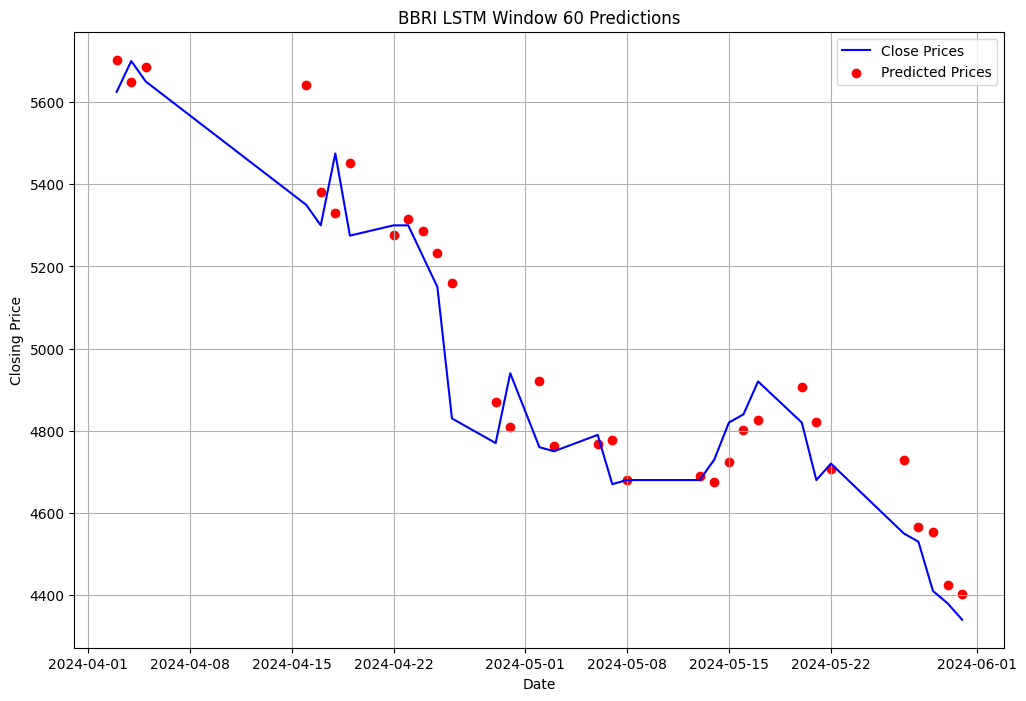

In [50]:
# Predictions for window size 60
length_difference = len(test_df) - len(pred60)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred60, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BBRI LSTM Window 60 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

### BRI GRU

In [51]:
start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)

train_df = currentdata("BBRI.JK", start_train, end_train)
test_df = currentdata("BBRI.JK", start_test, end_test)

from keras.models import load_model

horizon = 1
close_test = test_df['Close'].values

window_size = 5
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model5 = load_model('BBRI_GRU_window_5.h5')
pred5 = model.predict(X_test)

window_size = 20
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model20 = load_model('BBRI_GRU_window_20.h5')
pred20 = model.predict(X_test)

window_size = 60
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model60 = load_model('BBRI_GRU_window_60.h5')
pred60 = model.predict(X_test)

# Print the predictions
print(pred5.shape)
print(pred20.shape)
print(pred60.shape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 21ms/step
(87, 1)
(72, 1)
(32, 1)


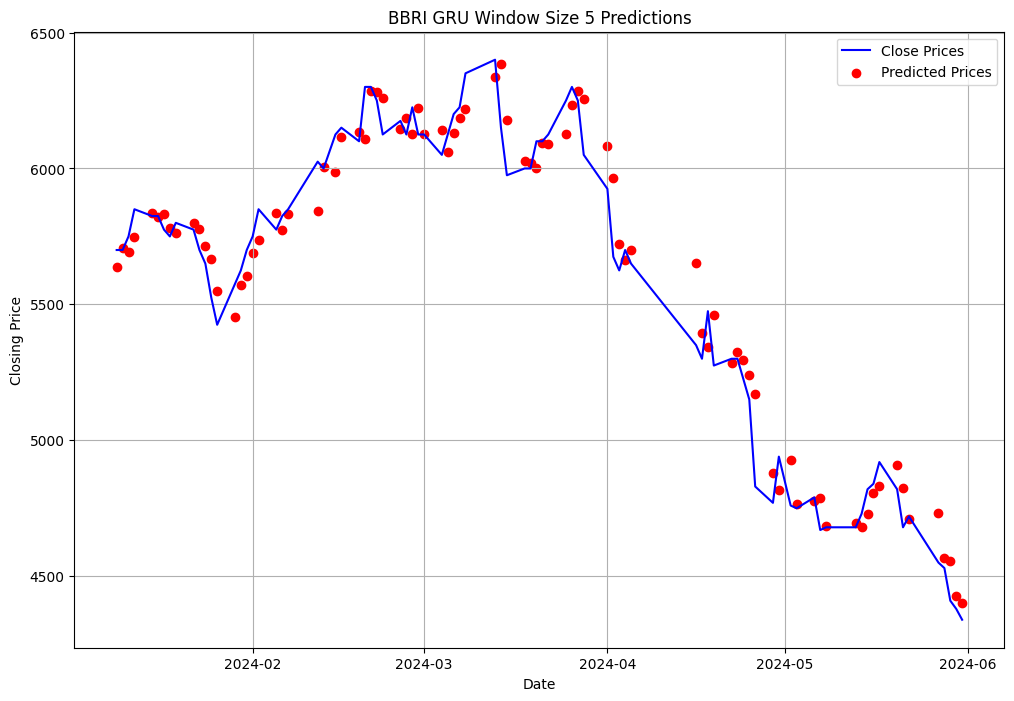

In [52]:
# Predictions for window size 5
length_difference = len(test_df) - len(pred5)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred5, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BBRI GRU Window Size 5 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

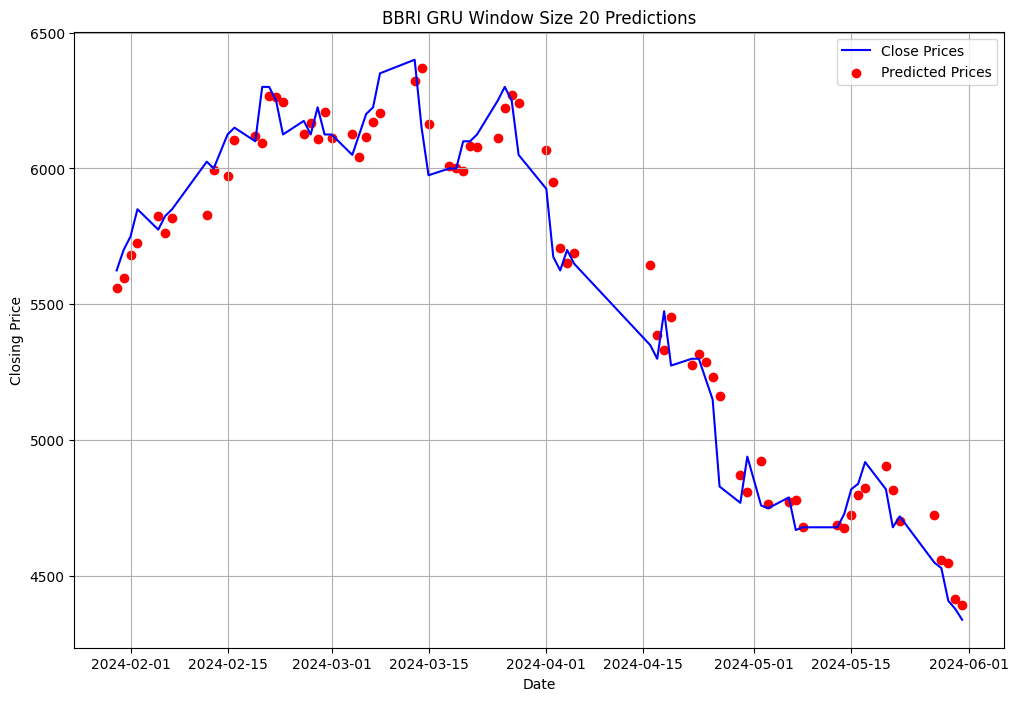

In [53]:
# Predictions for window size 20
length_difference = len(test_df) - len(pred20)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred20, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BBRI GRU Window Size 20 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

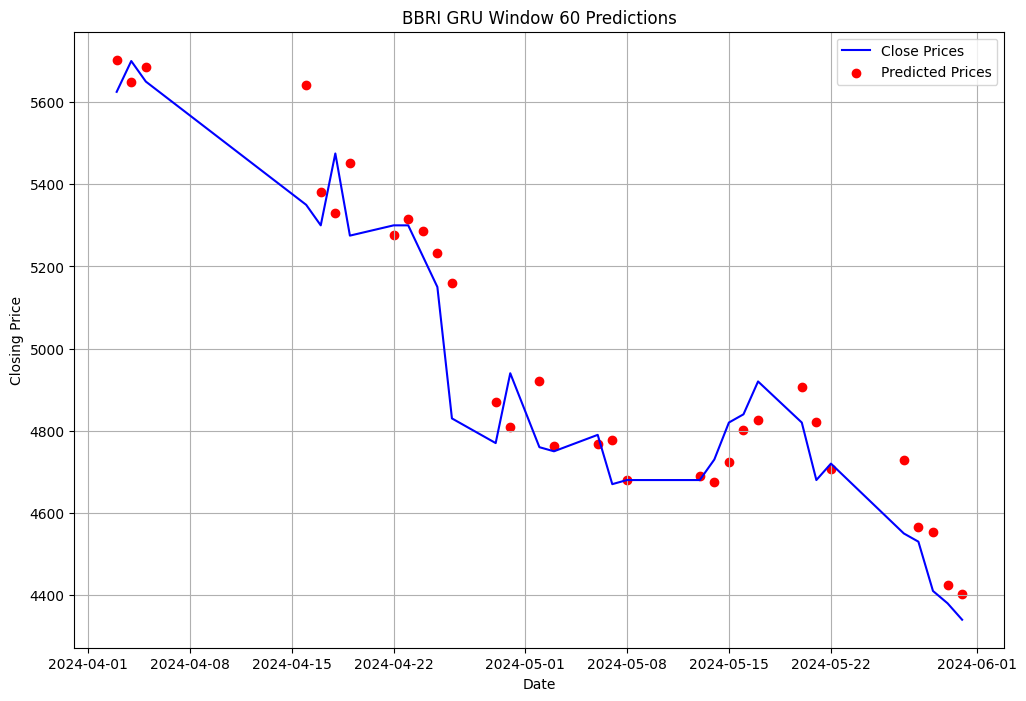

In [54]:
# Predictions for window size 60
length_difference = len(test_df) - len(pred60)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred60, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BBRI GRU Window 60 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

## MRI

### MRI LSTM

In [55]:
start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)

train_df = currentdata("BMRI.JK", start_train, end_train)
test_df = currentdata("BMRI.JK", start_test, end_test)

from keras.models import load_model

horizon = 1
close_test = test_df['Close'].values

window_size = 5
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model5 = load_model('BMRI_LSTM_window_5.h5')
pred5 = model.predict(X_test)

window_size = 20
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model20 = load_model('BMRI_LSTM_window_20.h5')
pred20 = model.predict(X_test)

window_size = 60
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model60 = load_model('BMRI_LSTM_window_60.h5')
pred60 = model.predict(X_test)

# Print the predictions
print(pred5.shape)
print(pred20.shape)
print(pred60.shape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 21ms/step
(87, 1)
(72, 1)
(32, 1)


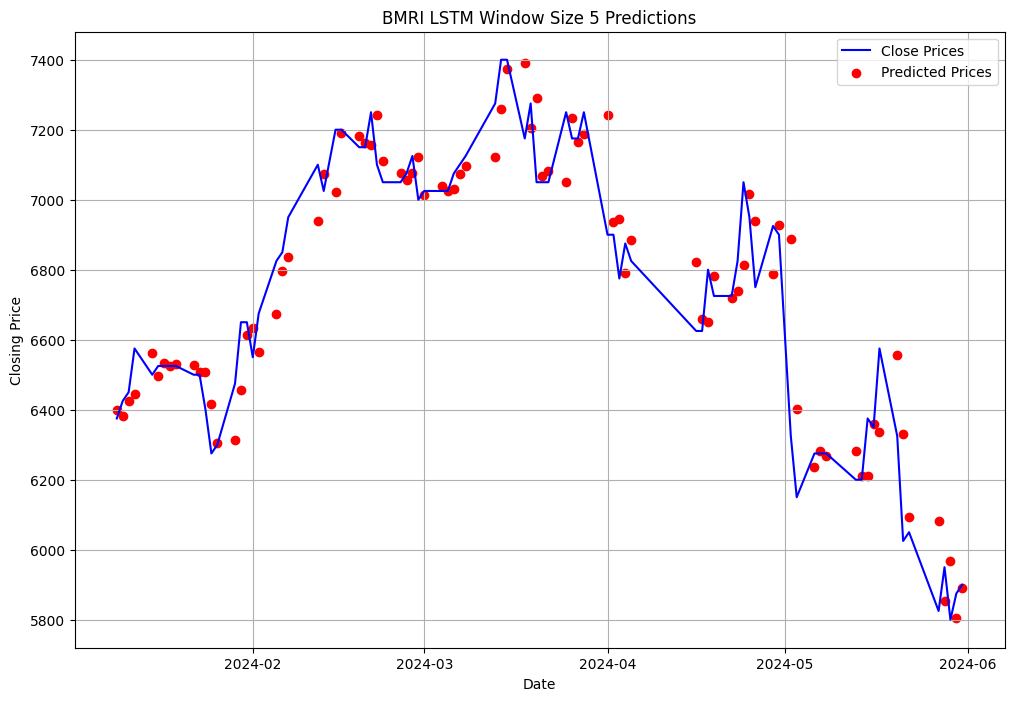

In [56]:
# Predictions for window size 5
length_difference = len(test_df) - len(pred5)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred5, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BMRI LSTM Window Size 5 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

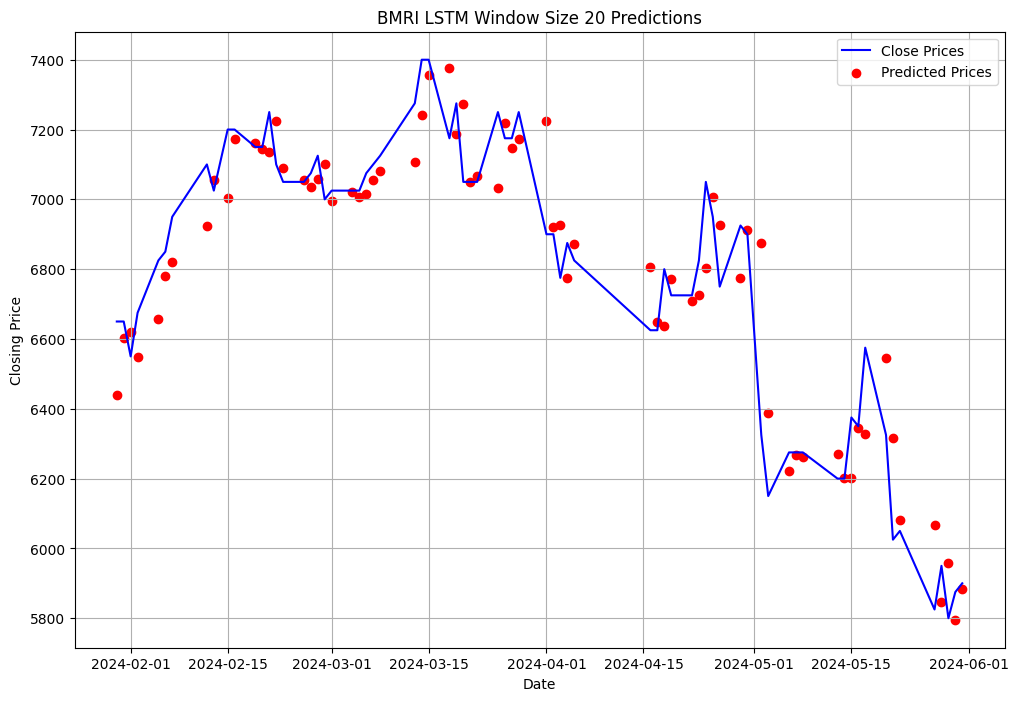

In [57]:
# Predictions for window size 20
length_difference = len(test_df) - len(pred20)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred20, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BMRI LSTM Window Size 20 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

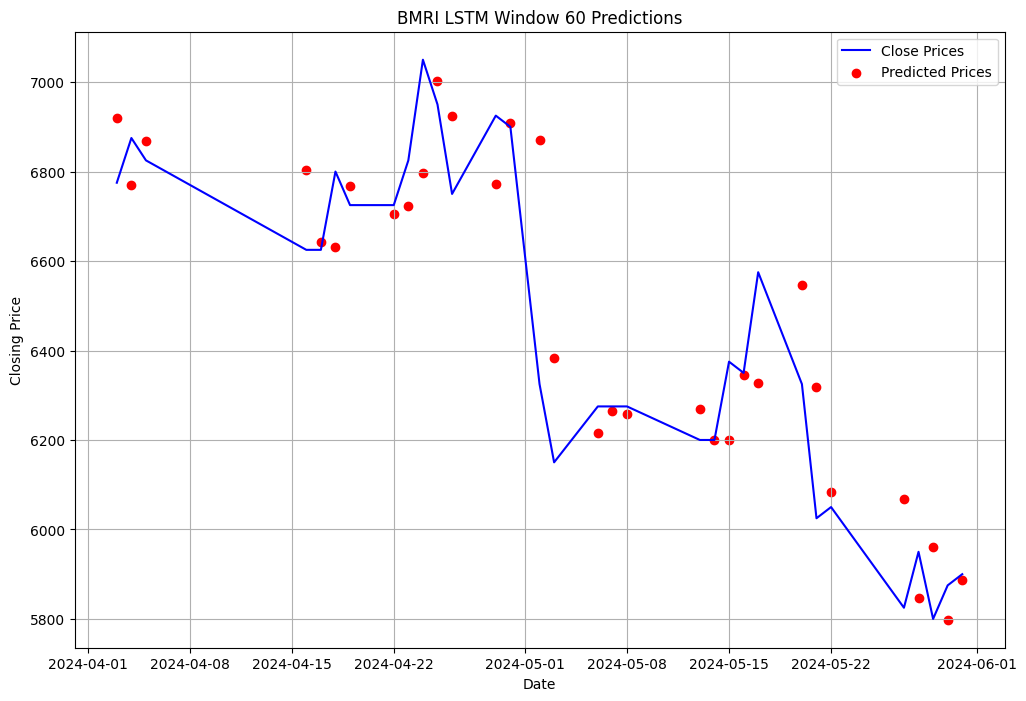

In [58]:
# Predictions for window size 60
length_difference = len(test_df) - len(pred60)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred60, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BMRI LSTM Window 60 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

### MRI GRU

In [59]:
start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)

train_df = currentdata("BMRI.JK", start_train, end_train)
test_df = currentdata("BMRI.JK", start_test, end_test)

from keras.models import load_model

horizon = 1
close_test = test_df['Close'].values

window_size = 5
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model5 = load_model('BMRI_GRU_window_5.h5')
pred5 = model.predict(X_test)

window_size = 20
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model20 = load_model('BMRI_GRU_window_20.h5')
pred20 = model.predict(X_test)

window_size = 60
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)
model60 = load_model('BMRI_GRU_window_60.h5')
pred60 = model.predict(X_test)

# Print the predictions
print(pred5.shape)
print(pred20.shape)
print(pred60.shape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 22ms/step
(87, 1)
(72, 1)
(32, 1)


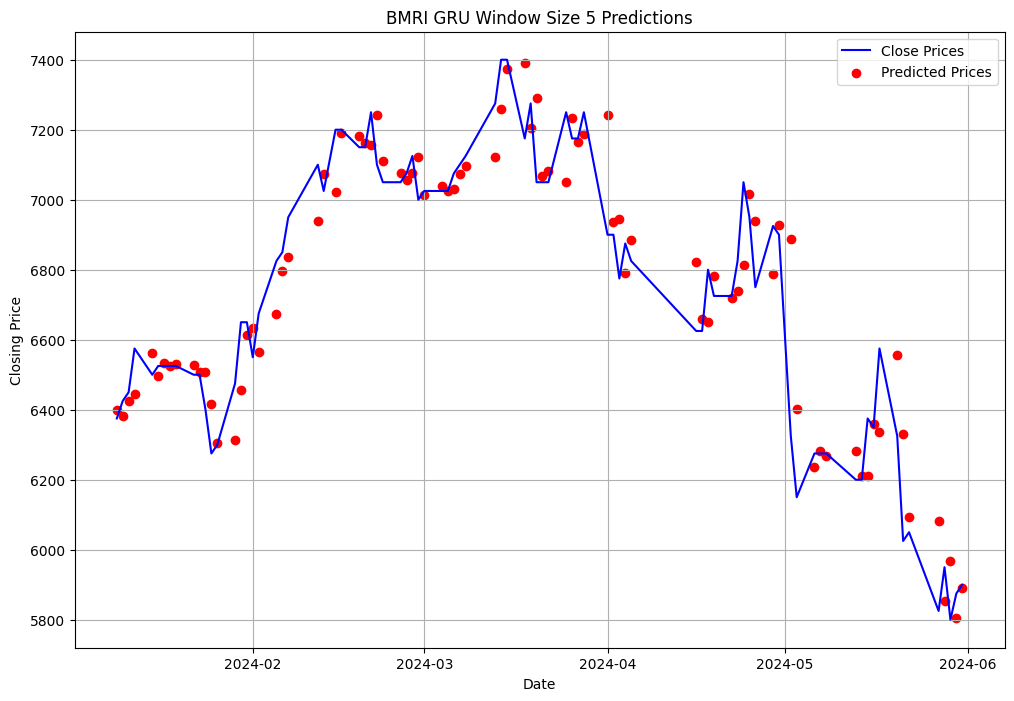

In [60]:
# Predictions for window size 5
length_difference = len(test_df) - len(pred5)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred5, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BMRI GRU Window Size 5 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

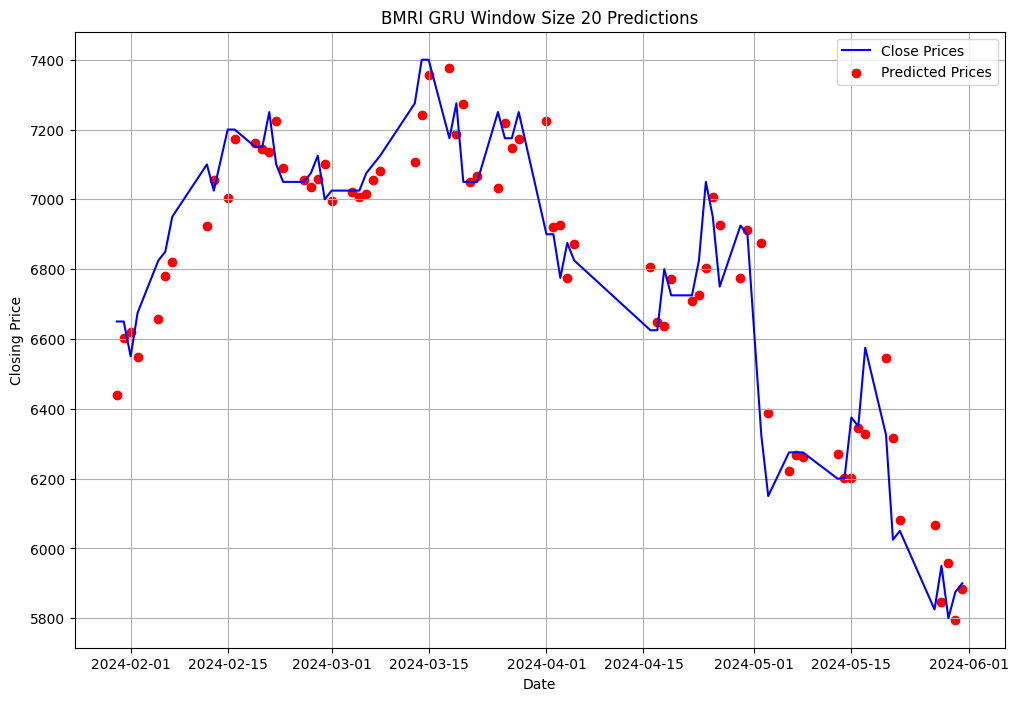

In [61]:
# Predictions for window size 20
length_difference = len(test_df) - len(pred20)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred20, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BMRI GRU Window Size 20 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()

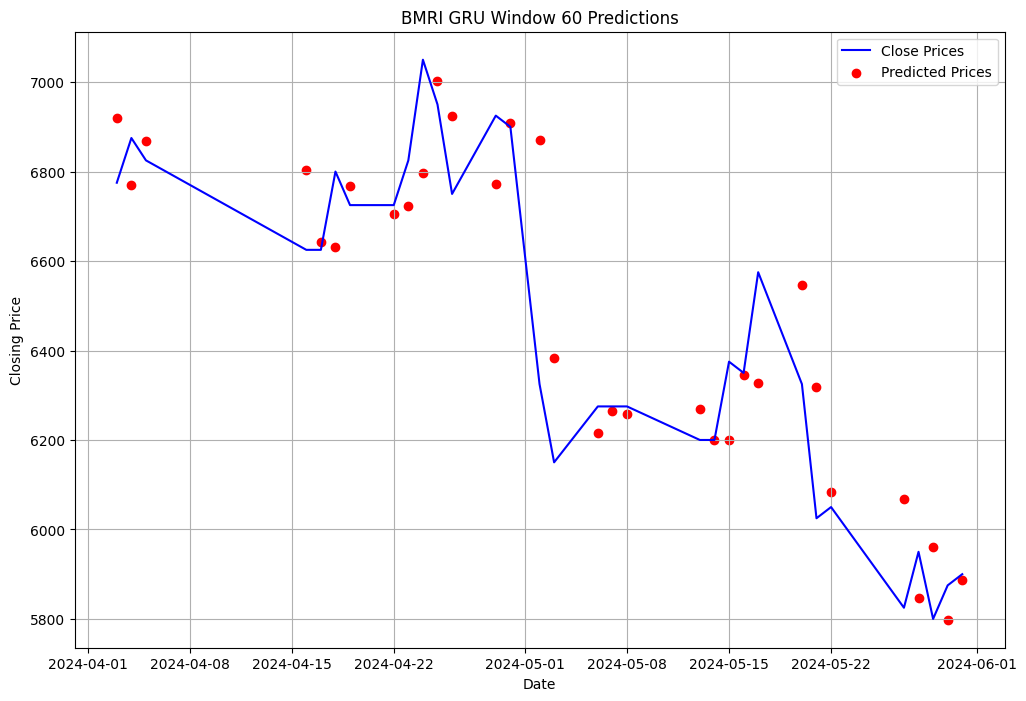

In [62]:
# Predictions for window size 60
length_difference = len(test_df) - len(pred60)
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(pred60, columns=['y_pred'])
test_df['y_pred'] = y_pred_df.values
test_df = test_df.dropna(subset=['y_pred'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

plt.legend()
plt.title('BMRI GRU Window 60 Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.show()